In [309]:
%pylab inline
import pandas as pd
from pandas import Series, DataFrame
import re
import datetime as dt
import matplotlib.pyplot as plt
#为了整数相除自动变小数，不round
from __future__ import division

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [129]:
import statsmodels.api as sm
from patsy import dmatrices
from sklearn import datasets, svm

### Data Cleaning

In [290]:
df = pd.read_csv('train.csv', header=0)
df_test = pd.read_csv('test.csv', header=0)
df.drop(['Ticket','Cabin','Embarked'], axis=1, inplace=True)
df_test.drop(['Ticket','Cabin','Embarked'], axis=1, inplace=True)
df_test['Survived']=-1

df_all=df.append(df_test)

In [291]:
# 通过不同分组的Age插值来fill missing age
df_all['Gender'] = df_all['Sex'].map( {'female': 0, 'male': 1} )
df['Gender'] = df['Sex'].map( {'female': 0, 'male': 1} )
df_test['Gender'] = df_test['Sex'].map( {'female': 0, 'male': 1} )

median_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = df_all[(df_all['Gender'] == i) & (df_all['Pclass'] == j+1)]['Age'].dropna().median()
df['AgeFill'] = df['Age']
df_test['AgeFill'] = df_test['Age']

median_ages

array([[ 36. ,  28. ,  22. ],
       [ 42. ,  29.5,  25. ]])

In [292]:
for i in range(0, 2):
    for j in range(0, 3):
        df.loc[ (df.Age.isnull()) & (df.Gender == i) & (df.Pclass == j+1),'AgeFill'] = median_ages[i,j]
        df_test.loc[ (df_test.Age.isnull()) & (df_test.Gender == i) & (df_test.Pclass == j+1),'AgeFill'] = median_ages[i,j]

In [293]:
print df_test['Age'].isnull().sum()
print df_test['AgeFill'].isnull().sum()
print df['Age'].isnull().sum()
print df['AgeFill'].isnull().sum()

86
0
177
0


In [294]:
df.drop(['Age'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

###数据显示

In [256]:
print df.shape
df.head()

(891, 10)


,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Fare,Gender,AgeFill
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,7.2500,1,22
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,71.2833,0,38
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,7.9250,0,26
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,53.1000,0,35
4,5,0,3,"Allen, Mr. William Henry",male,0,0,8.0500,1,35


In [267]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 10 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Gender         891 non-null int64
AgeFill        891 non-null float64
dtypes: float64(2), int64(6), object(2)
memory usage: 76.6+ KB


,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Gender,AgeFill
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.523008,0.381594,32.204208,0.647587,29.188182
std,257.353842,0.486592,0.836071,1.102743,0.806057,49.693429,0.477990,13.337887
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.420000
25%,223.500000,0.000000,2.000000,0.000000,0.000000,7.910400,0.000000,22.000000
50%,446.000000,0.000000,3.000000,0.000000,0.000000,14.454200,1.000000,26.000000
75%,668.500000,1.000000,3.000000,1.000000,0.000000,31.000000,1.000000,36.000000
max,891.000000,1.000000,3.000000,8.000000,6.000000,512.329200,1.000000,80.000000


In [268]:
df_test.info()
df_test.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 10 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Survived       418 non-null int64
Gender         418 non-null int64
AgeFill        418 non-null float64
dtypes: float64(2), int64(6), object(2)
memory usage: 35.9+ KB


,PassengerId,Pclass,SibSp,Parch,Fare,Survived,Gender,AgeFill
count,418.000000,418.000000,418.000000,418.000000,418.000000,418,418.000000,418.000000
mean,1100.500000,2.265550,0.447368,0.392344,35.559899,-1,0.636364,29.417464
std,120.810458,0.841838,0.896760,0.981429,55.857445,0,0.481622,12.974069
min,892.000000,1.000000,0.000000,0.000000,0.000000,-1,0.000000,0.170000
25%,996.250000,1.000000,0.000000,0.000000,7.895800,-1,0.000000,22.000000
50%,1100.500000,3.000000,0.000000,0.000000,14.454200,-1,1.000000,25.000000
75%,1204.750000,3.000000,1.000000,0.000000,31.471875,-1,1.000000,36.000000
max,1309.000000,3.000000,8.000000,9.000000,512.329200,-1,1.000000,76.000000


In [260]:
df_test[df_test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Fare,Survived,Gender,AgeFill
152,1044,3,"Storey, Mr. Thomas",male,0,0,NaN,-1,1,60.5


In [266]:
# 补上这一个fare是Nan的人
# Ticket 370160 7.5
# http://www.encyclopedia-titanica.org/titanic-passengers-and-crew/
df_test.loc[152,'Fare'] = 7.5

###Data overview

In [123]:
plt.rc('figure', figsize=(20, 10))

In [30]:
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55

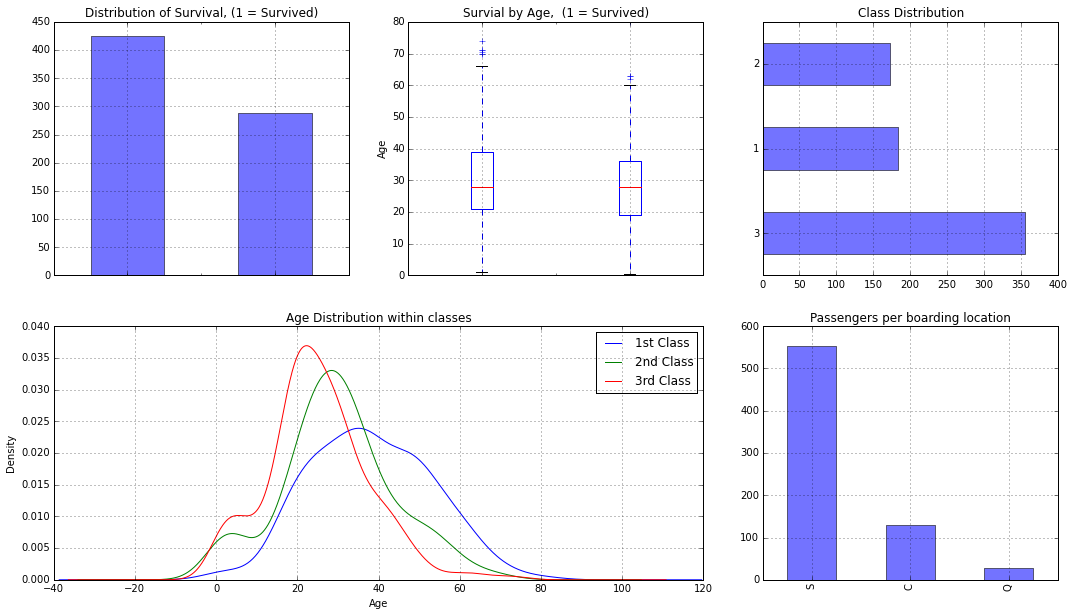

In [107]:
plt.subplot2grid((2,3),(0,0))
df['Survived'].value_counts().plot(kind='bar', alpha=alpha_bar_chart)
plt.title("Distribution of Survival, (1 = Survived)")    

plt.subplot2grid((2,3),(0,1))
data = [df[df['Survived'] == 0]['Age'].values, df[df['Survived'] == 1]['Age'].values]
plt.boxplot(data)
plt.ylabel("Age")
plt.grid(b=True)  
plt.title("Survial by Age,  (1 = Survived)")

plt.subplot2grid((2,3),(0,2))
df.Pclass.value_counts().plot(kind="barh", alpha=alpha_bar_chart)
plt.title("Class Distribution")

plt.subplot2grid((2,3),(1,0), colspan=2)
df.Age[df.Pclass == 1].plot(kind='kde')  
df.Age[df.Pclass == 2].plot(kind='kde') 
df.Age[df.Pclass == 3].plot(kind='kde')
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') 

plt.subplot2grid((2,3),(1,2))
df.Embarked.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
plt.title("Passengers per boarding location")

### Survival overview

0    360
1     93
dtype: int64
0    0.794702
1    0.205298
dtype: float64
1    195
0     64
dtype: int64
1    0.752896
0    0.247104
dtype: float64


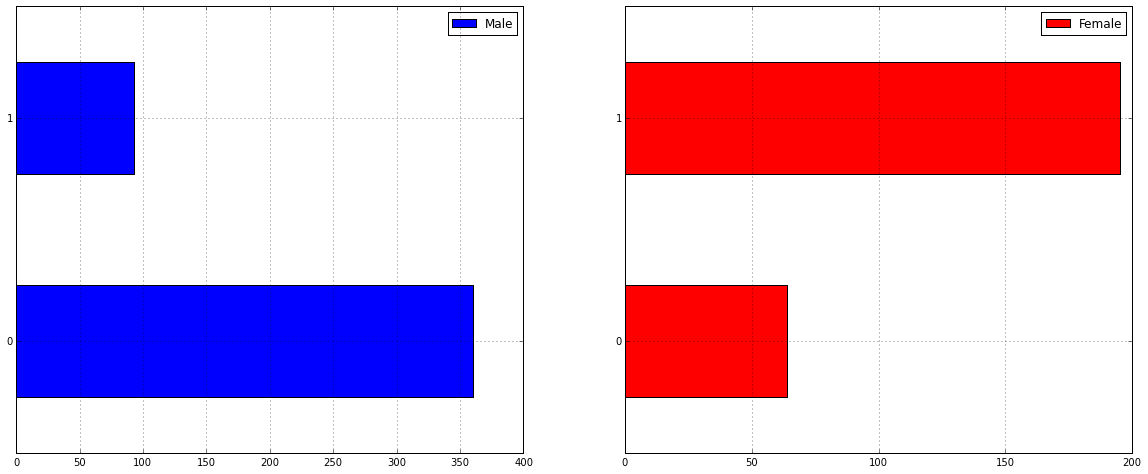

In [112]:
print df.Survived[df.Sex == 'male'].value_counts()
print df.Survived[df.Sex == 'male'].value_counts()/df.Sex[df.Sex == 'male'].size

print df.Survived[df.Sex == 'female'].value_counts()
print df.Survived[df.Sex == 'female'].value_counts()/df.Sex[df.Sex == 'female'].size

fig = plt.figure(figsize=(20,8))

plt.subplot2grid((1,2),(0,0))
df.Survived[df.Sex == 'male'].value_counts().sort_index().plot(kind='barh',label='Male')
plt.legend(loc='best')

plt.subplot2grid((1,2),(0,1))
df.Survived[df.Sex == 'female'].value_counts().sort_index().plot(kind='barh', color='r',label='Female')
plt.legend(loc='best')

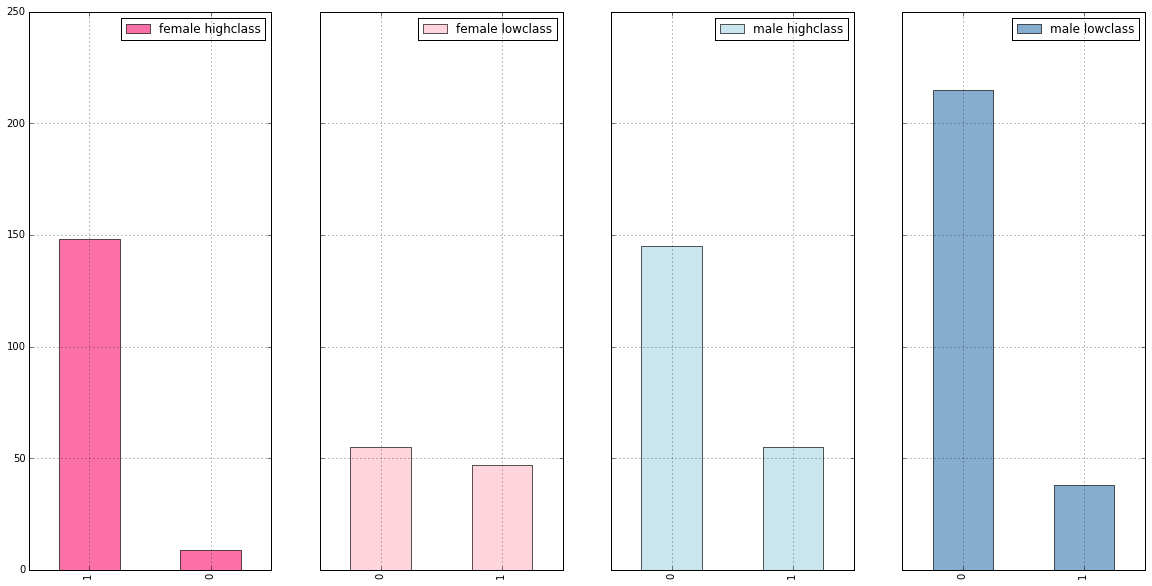

In [127]:
alpha_level = 0.65

fig, axes = plt.subplots(nrows=1,ncols=4,sharey=True)

data=df.Survived[df.Sex == 'female'][df.Pclass != 3].value_counts()
data.plot(kind='bar', label='female highclass', color='#FA2479', alpha=alpha_level, ax=axes[0])
axes[0].legend(loc='best')

data=df.Survived[df.Sex == 'female'][df.Pclass == 3].value_counts()
data.plot(kind='bar', label='female lowclass', color='pink', alpha=alpha_level, ax=axes[1])
axes[1].legend(loc='best')

data=df.Survived[df.Sex == 'male'][df.Pclass != 3].value_counts()
data.plot(kind='bar', label='male highclass', color='lightblue', alpha=alpha_level, ax=axes[2])
axes[2].legend(loc='best')

data=df.Survived[df.Sex == 'male'][df.Pclass == 3].value_counts()
data.plot(kind='bar', label='male lowclass', color='steelblue', alpha=alpha_level, ax=axes[3])
axes[3].legend(loc='best')

###Logistic Regression

In [269]:
x.head()

,Intercept,C(Pclass)[T.2],C(Pclass)[T.3],C(Sex)[T.male],Age,SibSp
0,1,0,1,1,22,1
1,1,0,0,0,38,1
2,1,0,1,0,26,0
3,1,0,0,0,35,1
4,1,0,1,1,35,0


In [270]:
y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [272]:
# formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + C(Embarked)' 
formula = 'Survived ~ C(Pclass) + C(Sex) + AgeFill + SibSp' 
y,x = dmatrices(formula, data=df, return_type='dataframe')
# instantiate our model
model = sm.Logit(y,x)
# fit our model to the training data
res = model.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.440436
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      885
Method:                           MLE   Df Model:                            5
Date:                Sat, 01 Aug 2015   Pseudo R-squ.:                  0.3386
Time:                        18:38:52   Log-Likelihood:                -392.43
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 1.215e-84
==================================================================================
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          4.3276      0.427     10.141      0.000         3.491     5.164
C(Pclass)[T.2]    -1.3293      0.270     -4.932      0.000        -1.858    -0.801
C(Pclass)[T.3]    -2.5831      0.262     -9.853      0.000        -3.097    -2.069
C(Sex)[T.male]    -2.7158      0.195    -13.931      0.000        -3.098    -2.334
AgeFill           -0.0456      0.008     -5.569      0.000        -0.062    -0.030
SibSp             -0.3805      0.105     -3.628      0.000        -0.586    -0.175
==================================================================================
"""

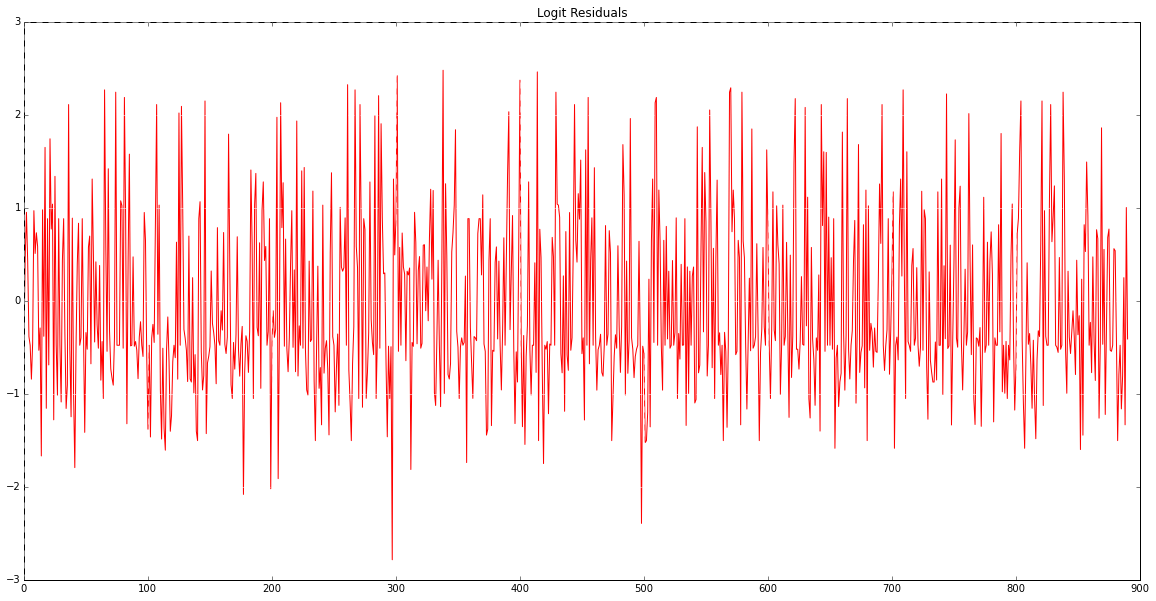

In [273]:
# Residuals
plt.plot(res.resid_dev, 'r-')
plt.grid(color='white', linestyle='dashed')
plt.title('Logit Residuals');

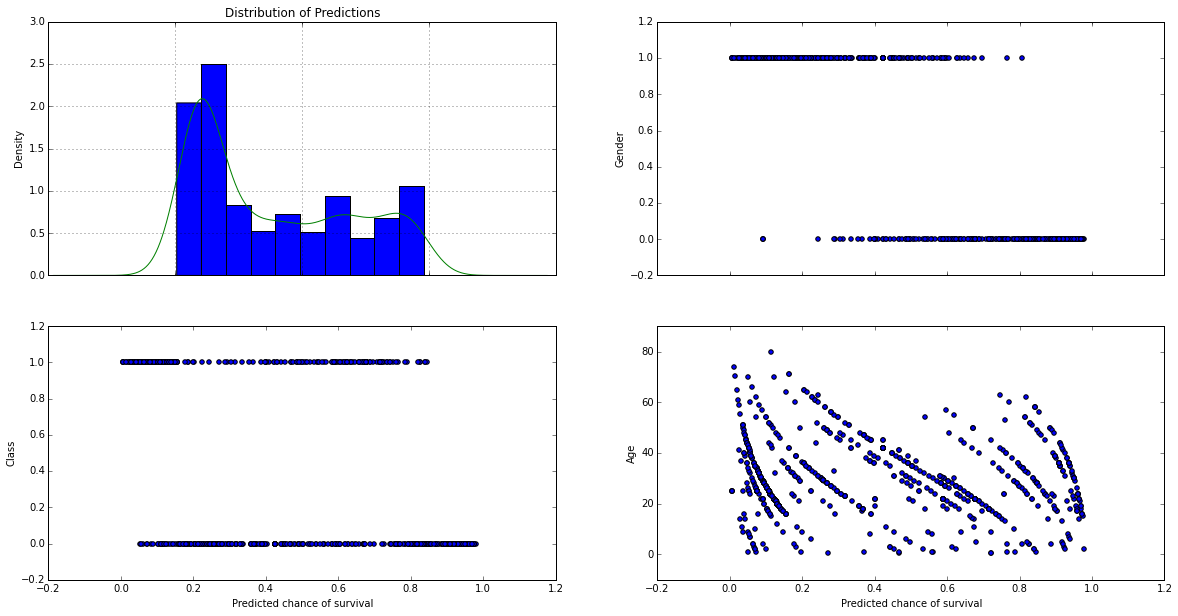

In [275]:
fig, axes = plt.subplots(nrows=2,ncols=2)

pred=Series(res.predict())
pred.hist(ax=axes[0,0],normed=True)
pred.plot(kind='kde',ax=axes[0,0])
axes[0,0].set_title('Distribution of Predictions')

axes[0,1].scatter(pred,x['C(Sex)[T.male]'])
axes[0,1].set_xlabel("Predicted chance of survival")
axes[0,1].set_ylabel("Gender")

axes[1,0].scatter(pred,x['C(Pclass)[T.3]'])
axes[1,0].set_xlabel("Predicted chance of survival")
axes[1,0].set_ylabel("Class")

axes[1,1].scatter(pred,x['AgeFill'])
axes[1,1].set_xlabel("Predicted chance of survival")
axes[1,1].set_ylabel("Age")

In [303]:
y_test, x_test = dmatrices(formula, data=df_test, return_type='dataframe')

In [298]:
print df_test.shape
print x_test.shape

(418, 10)
(418, 6)


In [281]:
df_test['Survived'] = res.predict(x_test)
df_test['Survived'] = df_test['Survived'].map(lambda x: 0 if x < 0.5 else 1)
df_test.head()

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Fare,Survived,Gender,AgeFill
0,892,3,"Kelly, Mr. James",male,0,0,7.8292,0,1,34.5
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,1,0,7.0000,0,0,47.0
2,894,2,"Myles, Mr. Thomas Francis",male,0,0,9.6875,0,1,62.0
3,895,3,"Wirz, Mr. Albert",male,0,0,8.6625,0,1,27.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,1,1,12.2875,1,0,22.0


In [279]:
df_test[['PassengerId','Survived']].to_csv('logistic_regression.csv',index=False)

###Random Forest

In [304]:
# import the machine learning library that holds the randomforest
import sklearn.ensemble as ske

# Create the random forest model and fit the model to our training data
y, x = dmatrices(formula, data=df, return_type='dataframe')
# RandomForestClassifier expects a 1 demensional NumPy array, so we convert
y = np.asarray(y).ravel()
#instantiate and fit our model
results_rf = ske.RandomForestClassifier(n_estimators=100).fit(x, y)

results_rf.score(x, y)

0.90460157126823793

In [307]:
df_test['Survived'] = results_rf.predict(x_test).astype(int)

In [308]:
df_test[['PassengerId','Survived']].to_csv('random_forest.csv',index=False)